<a href="https://colab.research.google.com/github/meysam-kazemi/face_detection_with_5_landmarks/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/landmark/ibug_300W_large_face_landmark_dataset

/content/drive/MyDrive/landmark/ibug_300W_large_face_landmark_dataset


In [3]:
%pwd

'/content/drive/MyDrive/landmark/ibug_300W_large_face_landmark_dataset'

In [4]:
%ls

 afw/                                   labels_5landmarks_test.xml    lfpw/
'Copy of face_landmarks_resnet18.pth'   labels_5landmarks_train.xml   output.csv
 helen/                                 labels_ibug_300W_test.xml     predictor_5_landmarks.dat
 ibug/                                  labels_ibug_300W_train.xml    predictor.dat
 image_metadata_stylesheet.xsl          labels_ibug_300W.xml          train.csv


In [5]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import *
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import models
from torch.utils.data import Dataset
import math

## A transformer for data

In [6]:
class Transforms():
    def __init__(self):
        pass

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

## Landmark detection

In [7]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('labels_5landmarks_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform

        for filename in root.find("images"):
            self.image_filenames.append(filename.attrib['file'])

            self.crops.append(filename.find("box").attrib)

            landmark = []
            for num in range(5):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

## A sample of dataset

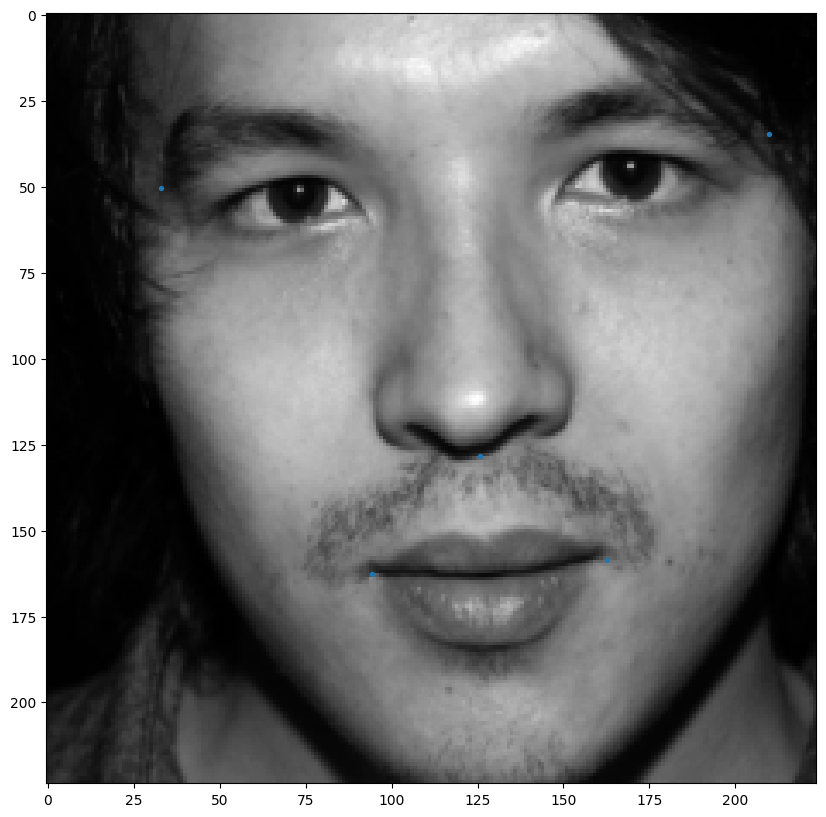

In [8]:
image, landmarks = dataset[4]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

## Split the dataset

In [9]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 5, 2])


## Build a Network - resnet18

In [11]:
class Network(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [12]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

## Train Model

In [13]:
# torch.autograd.set_detect_anomaly(True)
# network = Network()
# network.cuda()

# criterion = nn.MSELoss()
# optimizer = optim.Adam(network.parameters(), lr=0.0001)

# LOSS_MIN = np.inf
# NUM_EPOCHS = 15

# start_time = time.time()
# for epoch in range(1,NUM_EPOCHS+1):

#     loss_train = 0
#     loss_valid = 0
#     running_loss = 0

#     network.train()
#     for step in range(1,len(train_loader)+1):

#         images, landmarks = next(iter(train_loader))

#         images = images.cuda()
#         landmarks = landmarks.view(landmarks.size(0),-1).cuda()

#         predictions = network(images)

#         # clear all the gradients before calculating them
#         optimizer.zero_grad()

#         # find the loss for the current step
#         loss_train_step = criterion(predictions, landmarks)

#         # calculate the gradients
#         loss_train_step.backward()

#         # update the parameters
#         optimizer.step()

#         loss_train += loss_train_step.item()
#         running_loss = loss_train/step

#         print_overwrite(step, len(train_loader), running_loss, 'train')

#     network.eval()
#     with torch.no_grad():

#         for step in range(1,len(valid_loader)+1):

#             images, landmarks = next(iter(valid_loader))

#             images = images.cuda()
#             landmarks = landmarks.view(landmarks.size(0),-1).cuda()

#             predictions = network(images)

#             # find the loss for the current step
#             loss_valid_step = criterion(predictions, landmarks)

#             loss_valid += loss_valid_step.item()
#             running_loss = loss_valid/step

#             # print_overwrite(step, len(valid_loader), running_loss, 'valid')

#     loss_train /= len(train_loader)
#     loss_valid /= len(valid_loader)

#     print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
#     if loss_valid < LOSS_MIN:
#         LOSS_MIN = loss_valid
#         torch.save(network.state_dict(), 'face_landmarks_resnet18.pth')
#         print("\nMin Val Loss{:.4f} at epoch {}/{}".format(LOSS_MIN, epoch,NUM_EPOCHS))
#         print('..Model Saved..\n')

# print('Complete...')
# print(f"Total Time : {(time.time()-start_time)} s")

Total number of test images: 666
Elapsed Time : 3.382270336151123


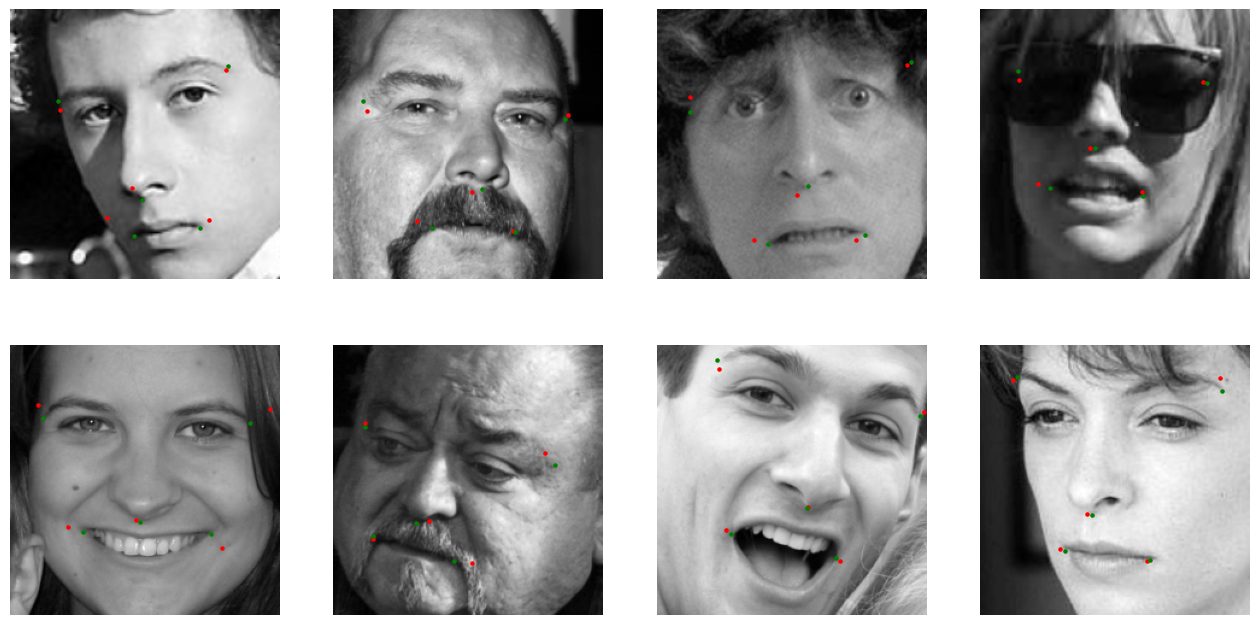

In [119]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('../face_landmarks_resnet18.pth'))
    best_network.eval()

    images, landmarks = next(iter(valid_loader))

    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,5,2)

    plt.figure(figsize=(16,8))

    for img_num in range(8):
        plt.subplot(2,4,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)
        plt.axis(False)
print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))

In [81]:
pred = predictions[0]

In [138]:
# calculate the roll angle (According to the corner of the eyebrows)
def calc_roll(left_eyebrow,right_eyebrow):
  delta_x = right_eyebrow[0] - left_eyebrow[0]
  delta_y = right_eyebrow[1] - left_eyebrow[1]
  roll_radians = -math.atan2(delta_y, delta_x)
  roll_degrees = math.degrees(roll_radians)
  return round(roll_degrees)

# calculate the pitch angle (According to the middle of lip points and nose tip)
def calc_pitch(mid_eyebrows,mid_lips,nose_tip):
  vertical_distance = mid_lips[0] - nose_tip[0]
  pitch_radians = math.atan(vertical_distance / abs(mid_eyebrows[1] - mid_lips[1]))
  pitch_degrees = math.degrees(pitch_radians)
  return round(pitch_degrees)

# calculate the yaw angle (According to the mid of lips and eyebrows, and nose tip)
def calc_yaw(mid_eyebrows,mid_lips,nose_tip):
  mid_x = (mid_eyebrows[0] + mid_lips[0]) / 2
  mid_y = (mid_eyebrows[1] + mid_lips[1]) / 2
  delta_x = nose_tip[0] - mid_x
  delta_y = nose_tip[1] - mid_y
  yaw_radians = -math.atan2(delta_x,delta_y)
  yaw_degrees = math.degrees(yaw_radians)
  return round(yaw_degrees)

def head_position(pred):
  # Define the landmark points
  nose_tip = pred[2]  # Index of the tip of the nose
  left_eyebrow = pred[0]  # Index of the left eyebrow
  right_eyebrow = pred[1]  # Index of the right eyebrow
  left_lip_corner = pred[3]  # Index of the left corner of the lips
  right_lip_corner = pred[4]  # Index of the right corner of the lips

  mid_eyebrows = (left_eyebrow + right_eyebrow) / 2
  mid_lips = (left_lip_corner + right_lip_corner) / 2

  roll = calc_roll(left_eyebrow,right_eyebrow)
  yaw = calc_yaw(mid_eyebrows,mid_lips,nose_tip)
  pitch = calc_pitch(mid_eyebrows,mid_lips,nose_tip)

  return (yaw , pitch , roll)

Text(0.5, 1.0, 'yaw:-1 - pitch:-2 - roll:-6')

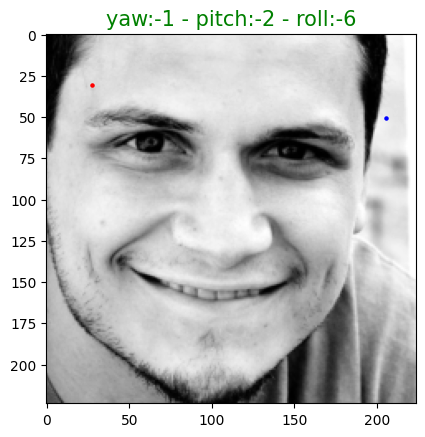

In [139]:
plt.imshow(img.cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(pred[0,0], pred[0,1], c = 'r', s = 5)
plt.scatter(pred[1,0], pred[1,1], c = 'b', s = 5)
yaw , pitch , roll = head_position(pred)
plt.title(f"yaw:{yaw} - pitch:{pitch} - roll:{roll}",color='g',size=15)


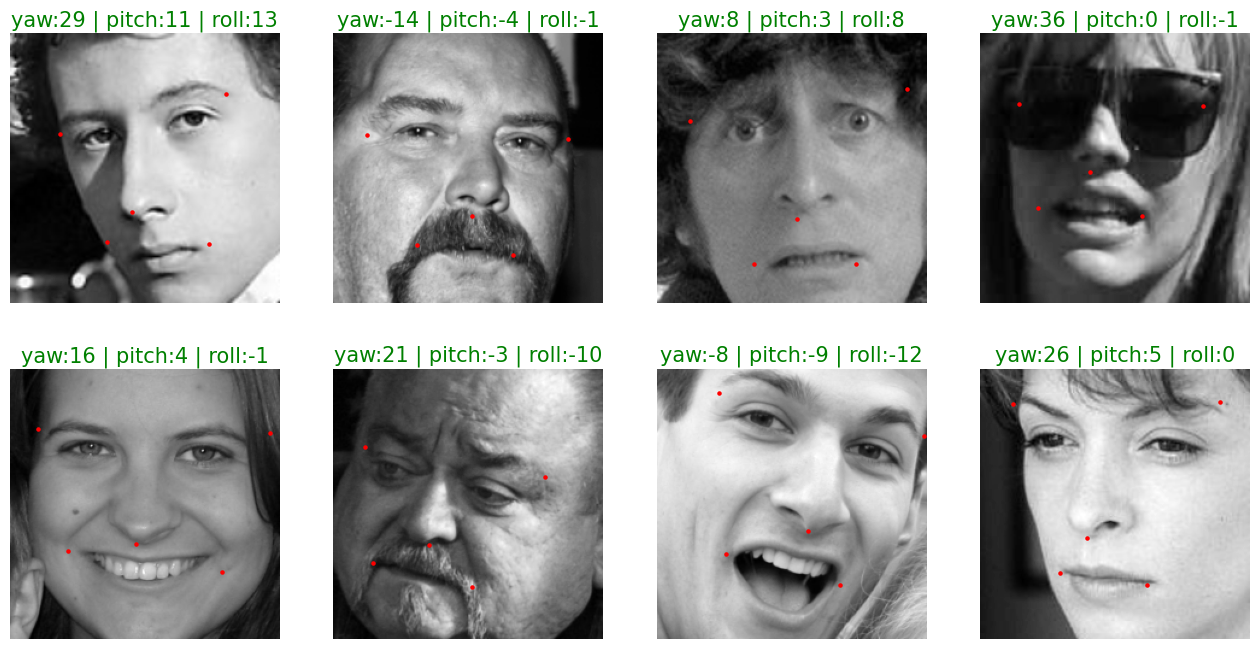

In [140]:
plt.figure(figsize=(16,8))
for img_num in range(8):
    plt.subplot(2,4,img_num+1)
    plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
    plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
    yaw , pitch , roll = head_position(predictions[img_num])
    plt.title(f"yaw:{yaw} | pitch:{pitch} | roll:{roll}",color='g',size=15)
    plt.axis(False)